<a href="https://colab.research.google.com/github/Mityal999/Evraz/blob/main/Solution_Evraz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорт

In [ ]:
from google.colab import files, drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Подготовка данных TRAIN

In [ ]:
#ДЛЯ МИТИ ПАША РУКИ ПРОЧЬ
!unzip -q '/content/drive/MyDrive/evraz_train.zip' -d '/content'

replace /content/chronom_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#ДЛЯ ПАШИ МИТЯ НЕ ТРОГАЙ
!unzip -q '/content/drive/MyDrive/evraz_train.zip' -d '/content/evraz_train'

In [ ]:
chronom = pd.read_csv('/content/evraz_train/chronom_train.csv')
chugun = pd.read_csv('/content/evraz_train/chugun_train.csv')
gas = pd.read_csv('/content/evraz_train/gas_train.csv')
lom = pd.read_csv('/content/evraz_train/lom_train.csv')
plavki = pd.read_csv('/content/evraz_train/plavki_train.csv')
produv = pd.read_csv('/content/evraz_train/produv_train.csv')
sip = pd.read_csv('/content/evraz_train/sip_train.csv')
target = pd.read_csv('/content/evraz_train/target_train.csv')

##Кислород

In [ ]:
sources_df = chugun[['NPLV', 'VES', 'T']]

In [ ]:
needed_part = chronom[~pd.isnull(chronom['O2'])  *  chronom['NOP'] == 'Нагрев лома']
o2 = needed_part[['NPLV', 'O2']]

In [ ]:
sources_df['O2'] = 0.0

In [ ]:
for i in o2['NPLV']:    
    sources_df['O2'][sources_df[sources_df['NPLV'] == i].index[0]]    =    o2['O2'][o2['NPLV'] == i].sum()

In [ ]:
sum_produv = produv.groupby(['NPLV'])['RAS'].sum()

In [ ]:
sources_df = sources_df.merge(sum_produv, on = 'NPLV')

In [ ]:
sources_df['O2_full'] = 0.0
sources_df['O2_full'] = sources_df['O2'] + sources_df['RAS']

In [ ]:
sources_df.drop(columns=['O2', 'RAS'], inplace=True)

In [ ]:
sources_df.shape

(2063, 4)

##Лом сип

In [ ]:
def total_ves(NPLV, VDSYP):
    mezh_rez = sip
    return mezh_rez[mezh_rez['NPLV'] == NPLV][mezh_rez['NMSYP']==VDSYP]['VSSYP'].sum()

for i in ["изв_ЦОИ","Уголь ТО","ФЛЮМАГ","Флюс ФОМИ","изв отсев","Долом(сыр)"]:
    for t in regr['NPLV']:
        regr[i][regr['NPLV']==t] = total_ves(NPLV=t, VDSYP=i)


In [ ]:
pashas_lom_sip.drop(columns=['Unnamed: 0', 'T_chugun'], inplace=True)

In [ ]:
pashas_lom_sip.shape

In [ ]:
sources_df = sources_df.merge(pashas_lom_sip, on = 'NPLV')

##Металлы

In [ ]:
sources_df = sources_df.merge(plavki[['NPLV', 'plavka_NMZ']].drop_duplicates(), on = 'NPLV', how='inner')

In [ ]:
steel_names = plavki[['plavka_NMZ']].append(  plavki_t[['plavka_NMZ']]  ).drop_duplicates()

In [ ]:
steel_names_list = np.squeeze(steel_names).tolist()

In [ ]:
for stl_name in steel_names_list:
    sources_df[stl_name] = (sources_df['plavka_NMZ'] == stl_name).astype(int)

In [ ]:
sources_df.drop(columns=['plavka_NMZ'], inplace=True)

In [ ]:
sources_df.drop(columns=['NPLV'], inplace=True)

In [ ]:
sources_df.drop(columns=['C'], inplace=True)

In [ ]:
sources_df

,VES,T,O2_full,изв_ЦОИ,Уголь ТО,ФЛЮМАГ,Флюс ФОМИ,изв отсев,Долом(сыр),pressure_o2,CO,CO2,К,КП,О,ЛЧ,25КШ,КШС8,У2КШ,ОК,СК,НБ,С255,Ст3пс/Э,Св-08А.z02,SC2M/ЭТ,Ш2.1,SC2/ЭТ,25Г2С,Ш2.3,Ст2пс,HRB400E.z03/ЭТ,4SP.z08/ЭТ,СТ3ГСП.2,45,09Г2С.16,СТ3ПС.6,Ст1пс/Э,20,Ст1кп,...,GR60.z06/ЭТ,40Х.1,CQ2-G60/ЭТ,26С2.2,28С,10ХСНД.1,СВ08Г2С.2,3PS.z03/Э,SP325/ЭТ,G/ЭТ,C071TM.z01/ЭТ,C06ESM.z01/ЭТ,Ст3Гпс,20.z22,15ХСНД,09Г2С.4,Ст2кп,Ст2пс/Э,C091TM.z01/ЭТ,GR60.z02/ЭТ,Ст5пс,10B33/ЭТ,SC3.z01/ЭТ,3SPPS.z03/Э,SAE1008.z13/ЭТ,09Г2СДП155,09Г2С.18,1PS.z02/ЭТ,3SP.z23/ЭТ,C121TM/ЭТ,08YU.z02/ЭТ,СТ3ПС.7,3SP.z24/ЭТ,5SP.z24/ЭТ,Ст1пс.z05/ЭТ,СТ3ГСП.4,Ст3сп/Т,Ст4сп/ЭТ,Ст3сп/ЭТ,Ст3пс
0,263700.0,1396.0,841723.0,14080.0,2950,2960,980,0,0,13.356058,41565.325339,34936.083312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,264500.0,1419.0,766932.0,18830.0,2930,0,960,1060,0,13.950163,45281.138686,46447.033896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,263800.0,1384.0,767011.5,16080.0,2990,2960,1050,990,0,14.022366,42363.861283,36527.960575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,264000.0,1401.0,733727.0,22150.0,3620,0,980,550,0,14.250926,44907.555298,44239.906145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,263300.0,1422.0,842602.0,19550.0,2930,3010,1000,2050,0,14.259779,40823.429399,39021.231253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,267200.0,1415.0,978520.0,14640.0,0,2890,0,0,0,15.004221,68561.374604,55072.672708,0.0,0.0,0.0,0.0,0.0,0.0,4100.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2059,266800.0,1405.0,783447.0,19210.0,960,2820,0,0,0,14.582193,57541.599778,48031.796573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2060,276100.0,1398.0,742971.0,19420.0,1380,2830,0,0,0,14.911266,68747.026782,45200.696418,0.0,0.0,0.0,0.0,0.0,0.0,17800.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2061,275800.0,1408.0,964755.5,16100.0,520,2310,0,0,0,15.110062,81828.992072,53715.803051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Выборка train

In [ ]:
# y_df = target[['TST']]
y_df = target[['C']]

In [ ]:
all_df = sources_df.merge(y_df, left_index=True, right_index=True)
all_df_clean = all_df.dropna()
all_df_clean.shape

(2061, 100)

In [ ]:
x_train_raw = all_df_clean.drop(columns=['C']).values

In [ ]:
y_train_raw = all_df_clean[['C']].values

In [ ]:
x_train_raw = all_df_clean.drop(columns=['TST']).values

In [ ]:
y_train_raw = all_df_clean[['TST']].values

In [ ]:
x_scaler = MinMaxScaler()
x_scaler.fit(x_train_raw)
x_train = x_scaler.transform(x_train_raw)

# Y_MAX = np.max(y_train_raw)
Y_MAX = 1
y_train = y_train_raw / Y_MAX

In [ ]:
x_train = x_train.copy()
y_train = y_train.copy()

In [ ]:
del sources_df
del all_df
del all_df_clean

#Подготовка данных TEST

In [ ]:
!unzip -q '/content/drive/MyDrive/evraz_test.zip' -d '/content'

In [ ]:
chronom = pd.read_csv('/content/evraz_test/chronom_test.csv')
chugun = pd.read_csv('/content/evraz_test/chugun_test.csv')
gas = pd.read_csv('/content/evraz_test/gas_test.csv')
lom = pd.read_csv('/content/evraz_test/lom_test.csv')
plavki = pd.read_csv('/content/evraz_test/plavki_test.csv')
produv = pd.read_csv('/content/evraz_test/produv_test.csv')
sip = pd.read_csv('/content/evraz_test/sip_test.csv')

##Сборка нужных данных

In [ ]:
sources_df = chugun[['NPLV', 'VES', 'T']]

In [ ]:
needed_part = chronom[~pd.isnull(chronom['O2'])  *  chronom['NOP'] == 'Нагрев лома']
o2 = needed_part[['NPLV', 'O2']]

In [ ]:
sources_df['O2'] = 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
for i in o2['NPLV']:    
    sources_df['O2'][sources_df[sources_df['NPLV'] == i].index[0]]    =    o2['O2'][o2['NPLV'] == i].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPyt

In [ ]:
sum_produv = produv.groupby(['NPLV'])['RAS'].sum()

In [ ]:
sources_df = sources_df.merge(sum_produv, on = 'NPLV')

In [ ]:
sources_df['O2_full'] = 0.0
sources_df['O2_full'] = sources_df['O2'] + sources_df['RAS']

In [ ]:
sources_df.drop(columns=['O2', 'RAS'], inplace=True)

In [ ]:
sources_df.shape

(780, 4)

Пашас-лом-сип

In [ ]:
pashas_lom_sip = pd.read_csv('/content/drive/MyDrive/regr_t.csv')

In [ ]:
pashas_lom_sip.drop(columns=['Unnamed: 0', 'T_chugun'], inplace=True)

In [ ]:
pashas_lom_sip.shape

(780, 21)

In [ ]:
sources_df = sources_df.merge(pashas_lom_sip, on = 'NPLV')

Плавки

In [ ]:
sources_df = sources_df.merge(plavki[['NPLV', 'plavka_NMZ']].drop_duplicates(), on = 'NPLV', how='inner')

In [ ]:
# steel_names_list берем из траинa

In [ ]:
for stl_name in steel_names_list:
    sources_df[stl_name] = (sources_df['plavka_NMZ'] == stl_name).astype(int)

In [ ]:
sources_df.drop(columns=['plavka_NMZ'], inplace=True)

In [ ]:
sources_df.drop(columns=['NPLV'], inplace=True)

In [ ]:
sources_df.drop(columns=['C'], inplace=True)

In [ ]:
sources_df

,VES,T,O2_full,изв_ЦОИ,Уголь ТО,ФЛЮМАГ,Флюс ФОМИ,изв отсев,Долом(сыр),pressure_o2,CO,CO2,К,КП,О,ЛЧ,25КШ,КШС8,У2КШ,ОК,СК,НБ,С255,Ст3пс/Э,Св-08А.z02,SC2M/ЭТ,Ш2.1,SC2/ЭТ,25Г2С,Ш2.3,Ст2пс,HRB400E.z03/ЭТ,4SP.z08/ЭТ,СТ3ГСП.2,45,09Г2С.16,СТ3ПС.6,Ст1пс/Э,20,Ст1кп,...,GR60.z06/ЭТ,40Х.1,CQ2-G60/ЭТ,26С2.2,28С,10ХСНД.1,СВ08Г2С.2,3PS.z03/Э,SP325/ЭТ,G/ЭТ,C071TM.z01/ЭТ,C06ESM.z01/ЭТ,Ст3Гпс,20.z22,15ХСНД,09Г2С.4,Ст2кп,Ст2пс/Э,C091TM.z01/ЭТ,GR60.z02/ЭТ,Ст5пс,10B33/ЭТ,SC3.z01/ЭТ,3SPPS.z03/Э,SAE1008.z13/ЭТ,09Г2СДП155,09Г2С.18,1PS.z02/ЭТ,3SP.z23/ЭТ,C121TM/ЭТ,08YU.z02/ЭТ,СТ3ПС.7,3SP.z24/ЭТ,5SP.z24/ЭТ,Ст1пс.z05/ЭТ,СТ3ГСП.4,Ст3сп/Т,Ст4сп/ЭТ,Ст3сп/ЭТ,Ст3пс
0,240100.0,1355.0,860961.0,13960.0,1310,1670,0,0,0,14.968114,33000.858450,39568.252094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,266400.0,1390.0,928172.0,15290.0,0,0,0,0,0,16.031891,42393.120691,44885.938358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,270200.0,1373.0,1023656.0,20010.0,0,0,0,0,0,16.087154,68213.928782,63900.041993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,266700.0,1383.0,831766.0,14060.0,0,0,0,0,0,16.043230,60682.816961,120860.136349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,267400.0,1387.0,725326.0,20100.0,0,0,0,0,0,16.000472,48747.540855,69962.102095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,280800.0,1324.0,708807.0,13990.0,2010,2980,0,0,0,15.915012,42830.951815,40524.695414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
776,280600.0,1389.0,693480.0,14030.0,2190,2750,0,0,0,15.934665,43326.865040,47517.380609,0.0,0.0,0.0,0.0,0.0,0.0,6600.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
777,279700.0,1332.0,961330.0,12380.0,2030,2920,0,0,0,15.942670,40325.309180,45669.892369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
778,279700.0,1378.0,861174.0,12010.0,0,2920,0,0,0,15.924325,33952.132058,47744.949786,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


##Выборка test

In [ ]:
sources_df_clean = sources_df.dropna()
sources_df_clean.shape

(780, 99)

In [ ]:
x_test_raw = sources_df_clean.values

In [ ]:
x_scaler = MinMaxScaler()
x_scaler.fit(x_test_raw)
x_test = x_scaler.transform(x_test_raw)

#Модель

In [ ]:
model = Sequential()

# model.add(BatchNormalization(input_dim=x_train.shape[1]))

model.add(Dense(256, activation='relu', input_dim=x_train.shape[1]))
model.add(Dropout(0.0))

model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.0))

model.add(Dense(16,  activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               25600     
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                

KeyError: ignored

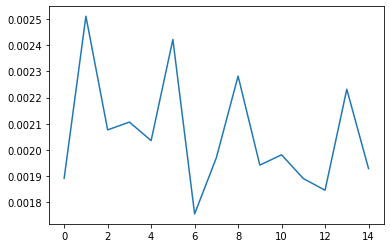

In [ ]:
model.compile(  loss='mse', 
                optimizer=Adam(learning_rate=1e-4), 
                metrics=['mae']  )

history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=15, 
                    verbose=0,
                    validation_split=0.0)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

# min_mae =     y_scaler.inverse_transform( [[min(history.history['mae'    ])]] )
min_val_mae =  min(history.history['val_mae']) * Y_MAX
# print('\n', 'min_mae=', min_mae[0][0])
print('\n', 'min_val_mae=',  min_val_mae)

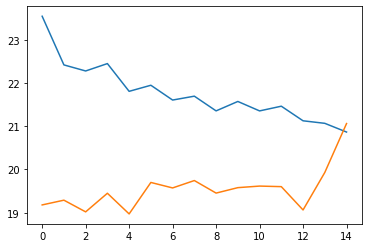

In [ ]:
scaled_mae = history.history['mae']
scaled_val_mae = history.history['val_mae']

scaled_mae = np.expand_dims(scaled_mae, axis=1)
scaled_val_mae = np.expand_dims(scaled_val_mae, axis=1)

# plt.plot(y_scaler.inverse_transform(scaled_mae))
# plt.plot(y_scaler.inverse_transform(scaled_val_mae))
plt.plot(scaled_mae * Y_MAX)
plt.plot(scaled_val_mae * Y_MAX)
plt.show()

In [ ]:
pred = model.predict(x_train)[:,0] * Y_MAX
true = y_train[:,0] * Y_MAX

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_scatter(y=true, name = 'true')
fig.add_scatter(y=pred, name = 'pred')
fig.show()

#Прогноз и экспорт

In [ ]:
#Carbon
y_test = model.predict(x_test)
y_test_С = y_test.copy()

In [ ]:
#Temp
y_test = model.predict(x_test) * Y_MAX
y_test_TST = y_test.copy()

In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
sample_submission

,NPLV,TST,C
0,512324,1640,0.0
1,512327,1640,0.0
2,512328,1640,0.0
3,512331,1640,0.0
4,512333,1640,0.0
...,...,...,...
775,513369,1640,0.0
776,513370,1640,0.0
777,513371,1640,0.0
778,513372,1640,0.0


In [ ]:
export_df = sample_submission.copy()

In [ ]:
export_df['C'] = y_test_С

In [ ]:
export_df['TST'] = y_test_TST

In [ ]:
export_df

,NPLV,TST,C
0,512324,1652.735107,0.055072
1,512327,1651.185913,0.056575
2,512328,1660.931030,0.070872
3,512331,1685.824707,0.051647
4,512333,1675.594849,0.067987
...,...,...,...
775,513369,1636.981323,0.064955
776,513370,1630.438354,0.070276
777,513371,1636.353027,0.061962
778,513372,1642.986816,0.057308


In [ ]:
export_folder = '/content/drive/MyDrive/'
export_name = 'submit.csv'
export_path = export_folder + export_name

export_df.to_csv(export_path, index=False, sep=',')
print('Done!')

Done!


#Autokeras

In [ ]:
%%capture
!pip install autokeras

In [ ]:
import autokeras as ak

In [ ]:
reg = ak.StructuredDataRegressor(
    overwrite=True, 
    max_trials=40,
    metrics='mae',
)

reg.fit(
    x=x_train,
    y=y_train,
    validation_split=0.1,
    epochs=50,
)

print(reg.evaluate(x=x_train, y=y_train))

Trial 40 Complete [00h 00m 36s]
val_loss: 0.012411617673933506

Best val_loss So Far: 0.009772837162017822
Total elapsed time: 00h 21m 50s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
65/65 [==============================] - 2s 6ms/step - loss: 0.0532 - mae: 0.1368
Epoch 2/50
65/65 [==============================] - 0s 6ms/step - loss: 0.0340 - mae: 0.1094
Epoch 3/50
65/65 [==============================] - 0s 5ms/step - loss: 0.0351 - mae: 0.0794
Epoch 4/50
65/65 [==============================] - 0s 5ms/step - loss: 0.0827 - mae: 0.1348
Epoch 5/50
65/65 [==============================] - 0s 6ms/step - loss: 0.0840 - mae: 0.1048
Epoch 6/50
65/65 [==============================] - 0s 6ms/step - loss: 0.0805 - mae: 0.1262
Epoch 7/50
65/65 [==============================] - 0s 6ms/step - loss: 0.0962 - mae: 0.1017
Epoch 8/50
65/65 [==============================] - 0s 5ms/step - loss: 0.0870 - mae: 0.1145
Epoch 9/50
65/65 [==============================] - 0s 5ms/step - loss: 0.0260 

In [ ]:
mae = reg.evaluate(x=x_train, y=y_train)[1]
print(mae*Y_MAX)

65/65 [==============================] - 0s 2ms/step - loss: 3.0928e-04 - mae: 0.0138
24.214545264840126


In [ ]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 21)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                704       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

#WANDB Sweep setup  (перебор гиперпараметров)
(я использую графический инструмент "Weights and Biases" для мониторинга результатов всех экспериментов, так что результаты смотрите в отчёте, прикрепленном к дз)

In [ ]:
# Имя проекта
PROJECT_NAME = "Solution_Evraz"

###__вспомогательные функции

In [ ]:
def two_pwr_list(a,b):

    return [2**i for i in range(a,b +1)]
def decimal_list(a,b):
    list = [round(x, 1) for x in np.arange(a, b/10, 0.1)]
    arr = np.array(list)
    return arr.tolist()

def static_iteration_on_lr(launches):
    default_lr = sweep_config['parameters']['T1_lr']['value']
    sweep_config['parameters']['T1_lr'] = {'values': [default_lr + default_lr/1000*i  for i in range(launches)]}

###__словарь свипа...

In [ ]:
# Установка дефолтных параметров свипа
sweep_config = {'method': 'grid'}

sweep_config['parameters'] = {
    'T1_bs': {'value': 32},
    'T1_lr': {'value': 1e-3},
    
    'T2_bs': {'value': 32},
    'T2_lr': {'value': 1e-4},


    # Dense
    'D1_neurons' : {'value' : 32},
    'D2_neurons' : {'value' : 0},
    'D3_neurons' : {'value' : 0},

    'Di_dropout': {'value': 0.2},    
    }


# Остальные изменяемые параметры
T1_EPOCHS = 50
T1_ES_PATIENCE = 999
T1_USE_MCP = False

T2_EPOCHS = 30
T2_ES_PATIENCE = 999
T2_USE_MCP = False


# Изменение некоторых дефолтных параметров свипа для перебора по ним
SWEEP_MODE = '0'

# Функция создания списка ничтожно разнящихся learinig_rate-ов (нужна для множественного запуска рана с одинаковыми параметрами)
if SWEEP_MODE == '0':
    static_iteration_on_lr(1)

if SWEEP_MODE == '1':
    sweep_config['parameters']['D1_neurons'] = {'values': [64,256]}
    sweep_config['parameters']['D2_neurons'] = {'values': [0,16,64]}
    sweep_config['parameters']['D3_neurons'] = {'values': [0,16,64]}
    static_iteration_on_lr(2)


# Вывести что получилось
print('T1_EPOCHS = ', T1_EPOCHS)
print('T1_ES_PATIENCE = ', T1_ES_PATIENCE)
print('T2_EPOCHS = ', T2_EPOCHS)
print('T2_ES_PATIENCE = ', T2_ES_PATIENCE)
print('\n')
sweep_config['parameters']

T1_EPOCHS =  50
T1_ES_PATIENCE =  999
T2_EPOCHS =  30
T2_ES_PATIENCE =  999




{'D1_neurons': {'value': 32},
 'D2_neurons': {'value': 0},
 'D3_neurons': {'value': 0},
 'Di_dropout': {'value': 0.2},
 'T1_bs': {'value': 32},
 'T1_lr': {'values': [0.001]},
 'T2_bs': {'value': 32},
 'T2_lr': {'value': 0.0001}}

###__ объявление модели и её обучения

In [ ]:
# Функция обучения модели для рана
def train(input_config=None):

    # Запуск рана
    with wandb.init(config=input_config):
        config = wandb.config
        C = config

        # Подгружаем конфиги
        T1_BS = C.T1_bs
        T1_LR = C.T1_lr

        T2_BS = C.T2_bs
        T2_LR = C.T2_lr


        # Объявление модели   
        model = Sequential()

        model.add(Dense(C.D1_neurons, activation='relu', input_dim=x_train.shape[1]))
        model.add(Dropout(C.Di_dropout))

        if C.D2_neurons > 0: 
            model.add(Dense(C.D2_neurons, activation='relu'))
            model.add(Dropout(C.Di_dropout))
            
        if C.D3_neurons > 0: 
            model.add(Dense(C.D3_neurons, activation='relu'))
            model.add(Dropout(C.Di_dropout))

        model.add(Dense(1, activation='relu'))
        

        print(model.summary())


        # Обучение 1
        model.compile(loss='mse', 
                      optimizer=Adam(learning_rate=C.T1_lr),
                      metrics=['mae'])

        es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=T1_ES_PATIENCE)
        callbacks = [es1, WandbCallback()]

        if T1_USE_MCP:
            mcp_path1 = '/content/drive/MyDrive/some_model_weights_T1.mdl_wts.hdf5'
            mcp_save1 = ModelCheckpoint(mcp_path1, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
            callbacks += [mcp_save1]

        history1 = model.fit(x_train, y_train, 
                            batch_size=C.T1_bs, 
                            epochs=T1_EPOCHS, 
                            verbose=0,
                            validation_split=0.2,
                            callbacks=callbacks)

        if T1_USE_MCP:
            model.load_weights(mcp_path1)
        

        # Обучение 2
        if T2_EPOCHS > 0:
            model.compile(loss='mse', 
                          optimizer=Adam(learning_rate=C.T2_lr),
                          metrics=['mae'])
                                
            es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=T2_ES_PATIENCE)  
            callbacks = [es2, WandbCallback()]

            if T2_USE_MCP:
                mcp_path2 = '/content/drive/MyDrive/some_model_weights_T2.mdl_wts.hdf5'
                mcp_save2 = ModelCheckpoint(mcp_path2, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
                callbacks += [mcp_save2]

            history2 = model.fit(x_train, y_train,
                                batch_size=C.T2_bs, 
                                epochs=T2_EPOCHS, 
                                verbose=0,
                                validation_split=0.2,
                                callbacks=callbacks)
            
            if T2_USE_MCP:
                model.load_weights(mcp_path2)


        # Доп статистика
        min_mae = min(history2.history['val_mae'])
        wandb.log({'min_val_mae': min_mae })

###__запуск свипа


In [ ]:
# Объявляем свип
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)
wandb.agent(sweep_id, train)

Create sweep with ID: 2qa2j3en
Sweep URL: https://wandb.ai/mityal999/Solution_Evraz/sweeps/2qa2j3en


wandb: Agent Starting Run: jyps3rht with config:
wandb: 	D1_neurons: 32
wandb: 	D2_neurons: 0
wandb: 	D3_neurons: 0
wandb: 	Di_dropout: 0.2
wandb: 	T1_bs: 32
wandb: 	T1_lr: 0.001
wandb: 	T2_bs: 32
wandb: 	T2_lr: 0.0001


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2816      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________
None


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅
loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▇▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
min_val_mae,▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▄▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,27
best_val_loss,0.00539
epoch,29
loss,0.00246
mae,0.02598


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
